# Linear Models

If we are willing to make assumptions about the **functional form** of the structural causal model or the **distribution of the errors**, we can go beyond the Markov equivalence class and identify the complete causal structure of the data-generating process. In this first chapter of semi-parametric models, we introduce the **linear non-Gaussian acyclic model (LiNGAM)** {cite}`shimizu2006linear`.

## The LiNGAM model

The LiNGAM model for $p$ observed variables $x_1, x_2, \ldots, x_p$ is given by

\begin{equation}
    x_i = \sum_{j \in \operatorname{pa}(x_i)}b_{ij}x_j + e_i \quad (i=1, \ldots, p)
\end{equation}

where each observed variable $x_i$ is a linear sum of their parent variables $\operatorname{pa}(x_i)$ plus some noise $e_i$. If the coefficient $b_{ij}$ is zero, then there is no direct causal effect from $x_j$ to $x_i$. The error variables $e_i$ are **independent** and follow continuous **non-Gaussian** distributions. The independence means there are **no unobserved or hidden common causes**.

In matrix notation, the model is given by

\begin{equation}
    \mathbf{x} = \mathbf{B}\mathbf{x} + \mathbf{e}
\end{equation}

where $\mathbf{x}$ and $\mathbf{e}$ are $p$-dimensional vectors, and $\mathbf{B}$ is a $p\times p$ matrix that contains the $b_{ij}$ coefficients, with $i, j=1, \ldots, p$.

Let us consider a simple **example** with three variables. To ease the introduction of the LiNGAM model, we will use the variables from the chain example of the previous chapters, where:
- **Wind forecast errors** are directly influences by sudden changes in the weather.
- **Balancing costs** are influenced by wind forecast errors. For example, if the system is short because it was expecting a larger production from wind farms, it might incur balancing costs to procure electricity from alternative sources.
- **Weather fluctuarions** are influenced by external factors and serve as an exogenous variable in this model.


### Strucural equations
If we know the coefficients of those causal relations, the **SCM** can be written as

\begin{align}
\text{wind forecast errors} &= 1.5 \times \text{weather flucturations} + e_f \\
\text{balancing costs} &= 1.2 \times \text{wind forecast errors} + e_b \\
\text{weather fluctuations} &= e_w \\
\end{align}



### Matrix notation
Then, in matrix notation, this model is given by

\begin{equation}
    \left[\begin{array}{c} 
    \text{wind forecast errors} \\
    \text{balancing costs} \\
    \text{weather fluctuations}
    \end{array}\right]
    =
    \left[\begin{array}{ccc}
    0 & 0 & 1.5 \\
    1.2 & 0 & 0 \\
    0 & 0 & 0
    \end{array}\right]
    \left[\begin{array}{c} 
    \text{wind forecast errors} \\
    \text{balancing costs} \\
    \text{weather fluctuations}
    \end{array}\right]
    +
    \left[\begin{array}{c}
    e_f \\
    e_b \\
    e_w
    \end{array}\right]
\end{equation}


### Causal ordering
Typically, we **order** the the structural equations according to the **true causal order**, so that the matrix $\mathbf{B}$ is permuted to be a **lower triangular matrix** (this property is used later on to identify the true structure), with all the diagonal elements equal to zero (strictly lower triangular). This simply means that we rewrite the structural equations as

\begin{align}
\text{weather fluctuations} &= e_w \\
\text{wind forecast errors} &= 1.5 \times \text{weather flucturations} + e_f \\
\text{balancing costs} &= 1.2 \times \text{wind forecast errors} + e_b \\
\end{align}

that, in matrix notation, becomes

\begin{equation}
    \left[\begin{array}{c} 
    \text{weather fluctuations} \\
    \text{wind forecast errors} \\
    \text{balancing costs}
    \end{array}\right]
    =
    \left[\begin{array}{ccc}
    0 & 0 & 0 \\
    1.5 & 0 & 0 \\
    0 & 1.2 & 0
    \end{array}\right]
    \left[\begin{array}{c} 
    \text{weather fluctuations} \\
    \text{wind forecast errors} \\
    \text{balancing costs}
    \end{array}\right]
    +
    \left[\begin{array}{c}
    e_w \\
    e_f \\
    e_b
    \end{array}\right]
\end{equation}

Now, we can rewrite the LiNGAM model as

\begin{equation}
    x_i = \sum_{j:k(j)<k(i)}b_{ij}x_j + e_i \quad (i=1, \ldots, p)
\end{equation}


where $k(\cdot)$ represents the causal ordering, meaning that each variable $x_i$ is a linear sum of the $x_j$ variables observed earlier in the causal graph ($k(j)<k(i)$), plus its own error variable $e_i$. We can now plot the **causal graph**, using the LiNGAM library.

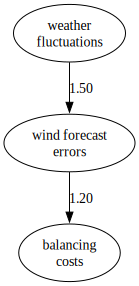

In [1]:
import numpy as np
from lingam.utils import make_dot

# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [1.5, 0.0, 0.0],
              [0.0, 1.2, 0.0]])

# Plotting causal graph
make_dot(m, labels=["weather \nfluctuations", "wind forecast \nerrors", "balancing \ncosts"])

## Estimation methods

Now that we explained the basic formulation, we explain how to **estimate the model from the data**. There are two main approaches to estimate a LiNGAM model: a direct estimation method (**DirectLiNGAM**) through a series of regressions and independence tests, and a method based on independent component analysis (ICA) (**ICA-based LinGAM**). In the case of linear models, the key assumption is that the **errors are non-Gaussians**. This is the most important assumption as it allows us to identify the causal structure, both using DirectLiNGAM and ICA-based LiNGAM.


Now, we will explain the intuition behing DirectLiNGAM, an iterative procedure that employs a series of regressions and independence tests to directly identify the causal order among the observed variables. It leverages the non-Gaussianity of the data and the assumption of linear causality to systematically test for independence between variables and their residuals from regressions. 

The key intuition is that, with non-Gaussian errors, the **residuals in the anti-causal direction** will not be independent of the predictor. We will see how this works with a practical example.

### Example with Gaussian errors
Let us consider a simple example, like the one we saw above, but for simplicity we only keep two variables:

\begin{align}
\text{weather fluctuations} &= e_w \\
\text{wind forecast errors} &= 1.5 \times \text{weather flucturations} + e_f \\
\end{align}

We now assume Gaussian errors, so we have that $e_w, e_f  \sim \mathcal{N}(0, 1)$.

We will show that, in this case, by analysing the residuals we cannot understand the true causal direction, because we can both predict the wind from the prices and the prices from the wind.

Text(0, 0.5, 'Residuals')

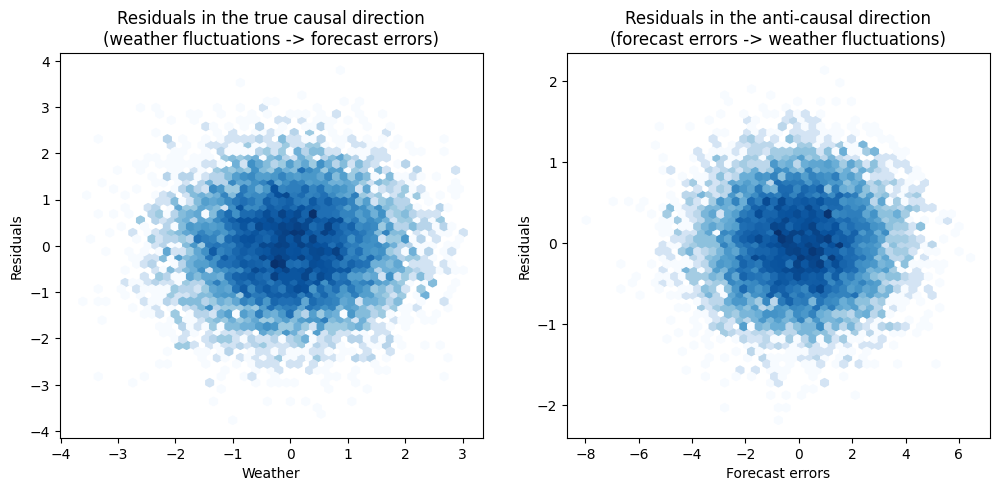

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Synthetic data generation based on the given equations
n = 10000
weather_fluctuations = np.random.normal(0, 1, size=n)  # Predictor variable
forecast_errors = 1.5 * weather_fluctuations + np.random.normal(0, 1, size=n)  # Response variable with non-Gaussian noise (uniform)

# Prepare the data for regression
weather_fluctuations_with_const = sm.add_constant(weather_fluctuations)  # Add a constant term for the intercept
forecast_errors_with_const = sm.add_constant(forecast_errors)  # Add a constant term for the intercept

# Linear regression in the true causal direction (wind -> price)
true_model = sm.OLS(endog=forecast_errors, exog=weather_fluctuations_with_const)
true_model_results = true_model.fit()
forecast_errors_pred = true_model_results.predict(weather_fluctuations_with_const)
forecast_errors_residuals = forecast_errors - forecast_errors_pred

# Linear regression in the anti-causal direction (price -> wind)
anti_model = sm.OLS(endog=weather_fluctuations, exog=forecast_errors_with_const)
anti_model_results = anti_model.fit()
weather_fluctuations_pred = anti_model_results.predict(forecast_errors_with_const)
weather_fluctuations_residuals = weather_fluctuations - weather_fluctuations_pred

# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All the data
hb1 = axes[0].hexbin(weather_fluctuations, forecast_errors_residuals, gridsize=50, cmap='Blues', bins='log')
axes[0].set_title('Residuals in the true causal direction\n(weather fluctuations -> forecast errors)')
axes[0].set_xlabel('Weather')
axes[0].set_ylabel('Residuals')

# After conditioning
hb2 = axes[1].hexbin(forecast_errors, weather_fluctuations_residuals, gridsize=50, cmap='Blues', bins='log')
axes[1].set_title('Residuals in the anti-causal direction\n(forecast errors -> weather fluctuations)')
axes[1].set_xlabel('Forecast errors')
axes[1].set_ylabel('Residuals')

Where we can see how the residuals are independent of the input variable in both the true and anti-causal directions.


### Example with non-Gaussian errors

Now, by simply assuming the errors are uniformly distributed, we can wee how it will be possible to detect the true causal direction by testing the independence of the residuals from the input variable.

Text(0, 0.5, 'Residuals')

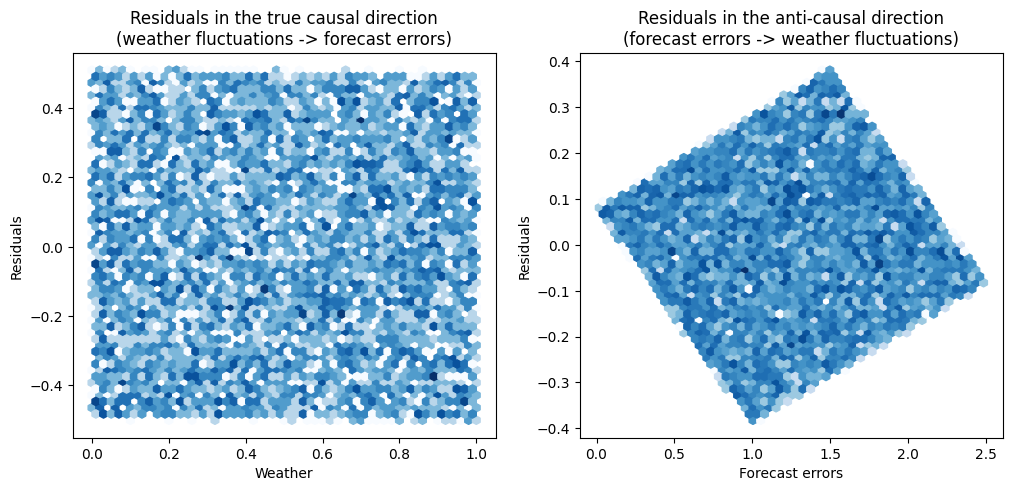

In [3]:
# Synthetic data generation based on the given equations
n = 10000
weather_fluctuations = np.random.uniform(0, 1, size=n)  # Predictor variable
forecast_errors = 1.5 * weather_fluctuations + np.random.uniform(0, 1, size=n)  # Response variable with non-Gaussian noise (uniform)

# Prepare the data for regression
weather_fluctuations_with_const = sm.add_constant(weather_fluctuations)  # Add a constant term for the intercept
forecast_errors_with_const = sm.add_constant(forecast_errors)  # Add a constant term for the intercept

# Linear regression in the true causal direction (wind -> price)
true_model = sm.OLS(endog=forecast_errors, exog=weather_fluctuations_with_const)
true_model_results = true_model.fit()
forecast_errors_pred = true_model_results.predict(weather_fluctuations_with_const)
forecast_errors_residuals = forecast_errors - forecast_errors_pred

# Linear regression in the anti-causal direction (price -> wind)
anti_model = sm.OLS(endog=weather_fluctuations, exog=forecast_errors_with_const)
anti_model_results = anti_model.fit()
weather_fluctuations_pred = anti_model_results.predict(forecast_errors_with_const)
weather_fluctuations_residuals = weather_fluctuations - weather_fluctuations_pred

# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All the data
hb1 = axes[0].hexbin(weather_fluctuations, forecast_errors_residuals, gridsize=50, cmap='Blues', bins='log')
axes[0].set_title('Residuals in the true causal direction\n(weather fluctuations -> forecast errors)')
axes[0].set_xlabel('Weather')
axes[0].set_ylabel('Residuals')

# After conditioning
hb2 = axes[1].hexbin(forecast_errors, weather_fluctuations_residuals, gridsize=50, cmap='Blues', bins='log')
axes[1].set_title('Residuals in the anti-causal direction\n(forecast errors -> weather fluctuations)')
axes[1].set_xlabel('Forecast errors')
axes[1].set_ylabel('Residuals')

### Full LiNGAM estimation example

Now, we try a full estimation example, where we have a slightly more complex causal structure, that we will need to retrieve from observational data. We now add to the model:
- **Outages**: an exogenous variable affecting the balancing costs.
- **heating demand**: a variable affected by changes in the weather, which affects the balancing costs.

Assume the following **structural equations**:

\begin{align}
\text{weather fluctuations} &= e_w \\
\text{outages} &= e_o \\
\text{heating demand} &= 0.3 \times \text{weather flucturations} + e_h \\
\text{wind forecast errors} &= 1.5 \times \text{weather flucturations} + e_f \\
\text{balancing costs} &= 1.5 \times \text{outages} + 0.7 \times \text{heating demand} + 1.2 \times \text{wind forecast errors} + e_b \\
\end{align}

where the errors are now assumed to be **uniformly distributed**.


Then, the true **causal graph** is given by

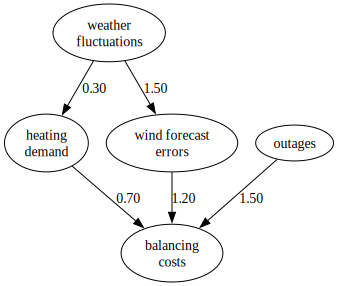

In [4]:
# Matrix of coefficients (weights)
B = np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0],   # Weather fluctuations
    [0.0, 0.0, 0.0, 0.0, 0.0],   # Outages
    [0.3, 0.0, 0.0, 0.0, 0.0],   # Heating demand
    [1.5, 0.0, 0.0, 0.0, 0.0],   # Wind forecast errors
    [0.0, 1.5, 0.7, 1.2, 0.0]    # Balancing costs
])

# Plotting causal graph
labels = ["weather \nfluctuations", "outages", "heating \ndemand", "wind forecast \nerrors", "balancing \ncosts"]
make_dot(B, labels=labels)

Let us now generate some data from this causal graph.

In [5]:
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Generating synthetic data based on the specified equations with uniform errors
weather_fluctuations = np.random.uniform(0, 1, size=n) 
outages = np.random.uniform(0, 1, size=n)
forecast_errors = 1.5 * weather_fluctuations + np.random.uniform(0, 1, size=n)
heating = 0.3 * weather_fluctuations + np.random.uniform(0, 1, size=n)
balancing_costs = 0.7 * heating + 1.2 * forecast_errors + 1.5 * outages + np.random.uniform(0, 1, size=n)

# Creating a DataFrame to hold the generated data
data = pd.DataFrame({'weather fluctuations': weather_fluctuations, 'outages': outages, 'wind forecast errors': forecast_errors,
                     'heating demand': heating, 'balancing costs': balancing_costs})

Now, we fit the **DirectLiNGAM** model and plot the estimated causal structure.

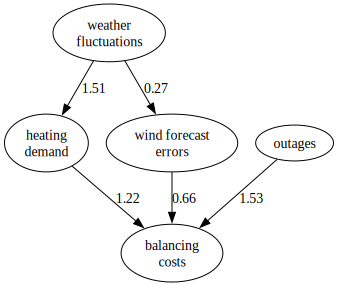

In [6]:
import lingam

direct_model = lingam.DirectLiNGAM()
direct_model.fit(data)
make_dot(direct_model.adjacency_matrix_, labels=labels)

We can see how we successfully recovered the true casual structure, even though the model did not find the exact coefficients for the wind forecast errors and heating demand.